# Laboratorio

In [1]:
# Importando librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence \
    import variance_inflation_factor as VIF
from statsmodels.stats.anova import anova_lm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS, summarize, poly)

In [2]:
# Lectura de la base de datos
Boston = load_data("Boston")
Boston.columns

Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'lstat', 'medv'],
      dtype='object')

# Descripción de variables
### CRIM - per capita crime rate by town
### ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
### INDUS - proportion of non-retail business acres per town.
### CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
### NOX - nitric oxides concentration (parts per 10 million)
### RM - average number of rooms per dwelling
### AGE - proportion of owner-occupied units built prior to 1940
### DIS - weighted distances to five Boston employment centres
### RAD - index of accessibility to radial highways
### TAX - full-value property-tax rate per $10,000
### PTRATIO - pupil-teacher ratio by town
### LSTAT - % lower status of the population
### MEDV - Median value of owner-occupied homes in $1000's

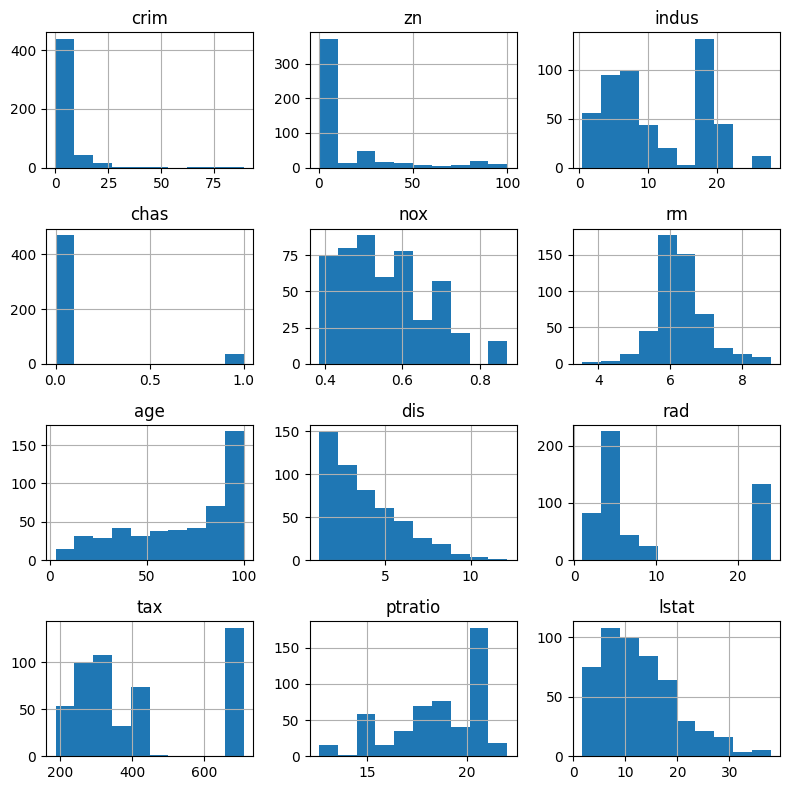

In [3]:
# Histogramas
Boston.drop(columns = "medv").hist(figsize = (8, 8));
plt.tight_layout()

* Las variables crim y zn están infladas en valores bajos y muestran colas derechas bastantes pesadas. Estos valores extremos podrían ser outliers o, incluso, puntos de influencia pensando en el ajuste de un modelo lineal, por lo tanto hay que prestarles atención en un posible ajuste con estas variables.
* Respecto a nox, se podría pensar que la variable no es significativa debido a que en un importante rango de valores de esta, parece distribuirse de forma uniforme, sin embargo, no es claro debido a la no constancia de dicho comportamiento en los valores más altos de la misma variables.
* rad y tax presentan una cantidad no despreciable de datos en los extremos derechos de sus distribuciones, lo cual podría sugerir la existencia de más de una población dentro es estas variables (distribuciones bimodales).
* El histograma de la variable indus también sugiere la existencia de más de una población pero con un separación menos agresiva respecto a las vistas en rad y tax.

C:\Users\usuario\AppData\Local\Temp\ipykernel_4448\4235440437.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout();
C:\Users\usuario\AppData\Local\Temp\ipykernel_4448\4235440437.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout();
C:\Users\usuario\AppData\Local\Temp\ipykernel_4448\4235440437.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout();
C:\Users\usuario\AppData\Local\Temp\ipykernel_4448\4235440437.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout();
C:\Users\usuario\AppData\Local\Temp\ipykernel_4448\4235440437.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout();
C:\Users\usuario\AppData\Local\Temp\ipykernel_4448\4235440437.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout();
C:\Users\usuario\AppData\Local\Temp\ipykernel_4448\4235440437.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout();
C:\Use

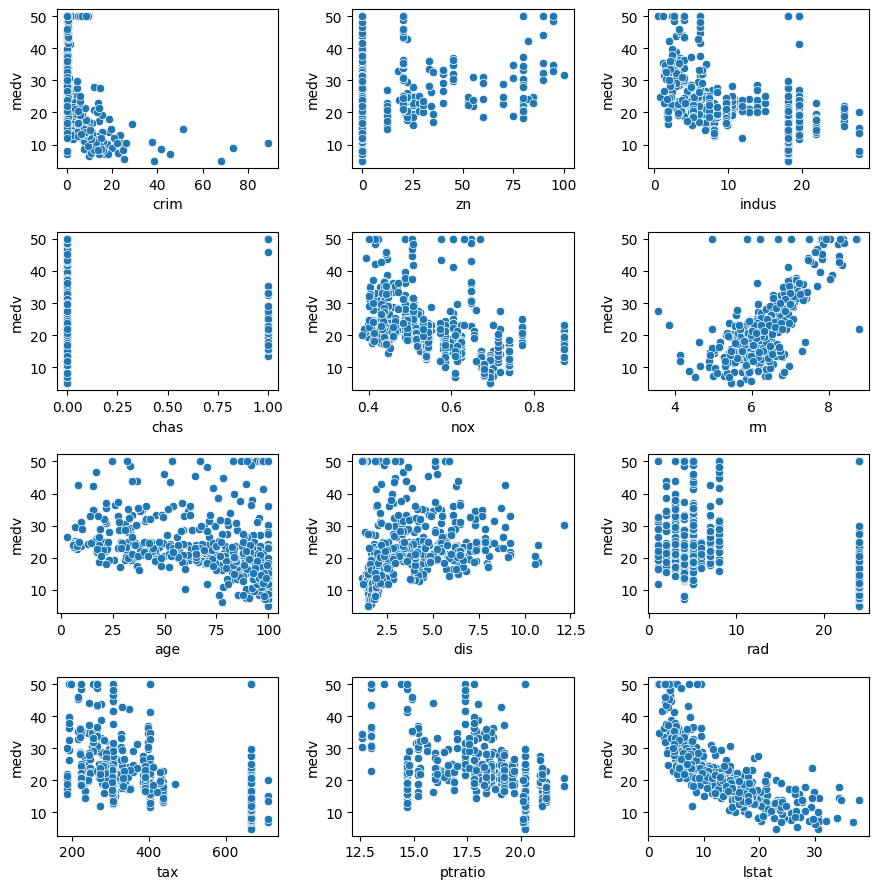

In [4]:
nrow, ncol = 4, 3
fig, ax = plt.subplots(nrows = nrow, ncols = ncol, figsize = (9, 9))

aux = 0
for i in range(nrow):
    for j in range(ncol):
        plt.tight_layout();
        sns.scatterplot(y = "medv", x = Boston.iloc[:, aux], data = Boston, ax = ax[i][j]);
        aux += 1

* Las variables que muestran una mayor asociación con la respuesta son rm y lstat, esta última muestra una asociación no lineal.
* zn, indus y, tal vez, nox presentan cierto grado de asociación pero no muy fuerte.
* El resto de variables, no parecen tener algún tipo de relación con la respuesta.
* La variable chas se analiza por aparte debido a que es de naturaleza categórica.

chas
0    471
1     35
Name: count, dtype: int64

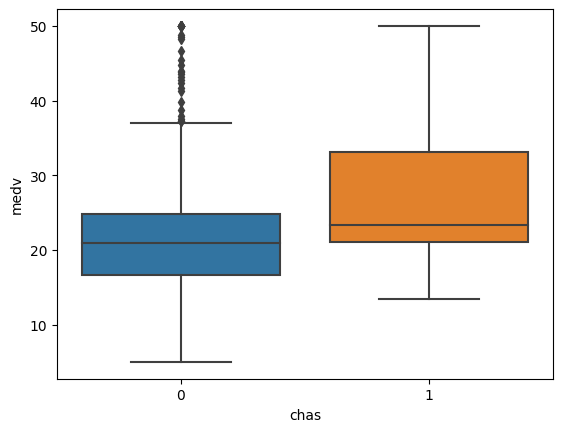

In [5]:
# Boxplot
sns.boxplot(y = "medv", x = "chas", data = Boston);
# Conteo por categorias
Boston["chas"].value_counts()

Aunque existe solapamiento entre las cajas, parece que las casas que límitan con el rio Charles presentan un valor mediano mayor (en miles de dolares), sin embargo, un dato importante a tener en cuenta es el hecho de que la cantidad de personas con esta característica de hogar es mucho menor respecto a quienes poseen casas que no límitan con el rio.

Hasta este punto se tienen las siguientes variables tentativas:
* rm
* lstat
* zn
* indus
* nox
* chas

Las últimas 4 son dudosas pero se dejan para evaluar su contribución a los modelos.

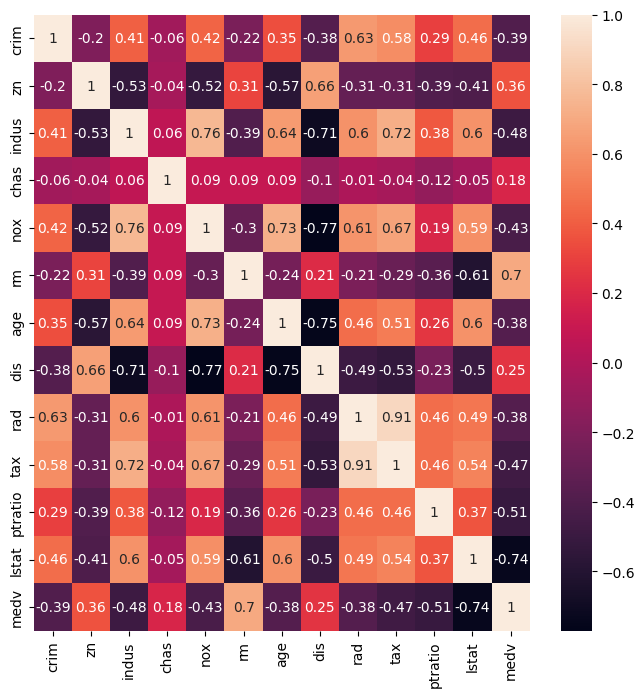

In [6]:
# Multicolinealidad
# Matriz de correlación completa
plt.figure(figsize = (8, 8))
sns.heatmap(Boston.corr().round(2), annot = True);

De la matriz de correlación completa, se destacan las variables ptratio, tax y rad debido a no ser consideradas, en un principio, para el análisis y su mdoerada correlación con la respuesta.
* ptratio
* tax
* rad

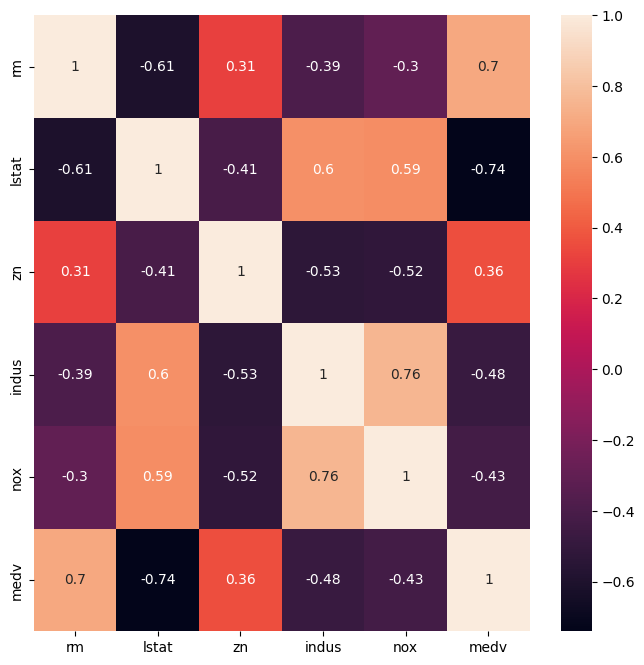

In [7]:
# Matriz de correlación reducida
vars = ["rm", "lstat", "zn", "indus", "nox", "medv"]
plt.figure(figsize = (8, 8))
sns.heatmap(Boston[vars].corr().round(2), annot = True);

* Las variables rm y lstat tienen una alta correlación con la respuesta por lo que pueden ser importantes al momento de ajustar un modelo, sin embargo, presentan una importante correlación entre sí por lo que hay que mirarlas con cuidado.
* Las otras variables no parecen ser muy útiles; se podría intentar con indus debido a su correlación de casi -0.5 con la respuesta y, tal vez, nox.

# Resumen
* rm, lstat -> Mandatorias
* indus, nox, ptratio, tax, rad, chas (categórica) -> Opcionales
* zn y el resto -> Descartadas

# Replicas del Lab

# Regresión simple
## Framework manual

In [8]:
# Matriz de diseno
# Se crea un dataframe con la columna de unos y las covariables a usar
X = pd.DataFrame({'intercept': np.ones(Boston.shape[0]), 'lstat': Boston['lstat']})
X.head()

,intercept,lstat
0,1.0,4.98
1,1.0,9.14
2,1.0,4.03
3,1.0,2.94
4,1.0,5.33


In [9]:
# Se define la respuesta
y = Boston['medv']
# Ajuste del modelo
model = sm.OLS(y, X)
results = model.fit()
# Resumen de coeficientes de regresion
summarize(results)

,coef,std err,t,P>|t|
intercept,34.5538,0.563,61.415,0.0
lstat,-0.9500,0.039,-24.528,0.0


## Framework usando la clase ModelSpec()

In [10]:
design = MS(['lstat'])
design = design.fit(Boston)
X = design.transform(Boston)
X.head()
# Nota: También existe el metodo fit_transform() que funciona igual que en sklearn

,intercept,lstat
0,1.0,4.98
1,1.0,9.14
2,1.0,4.03
3,1.0,2.94
4,1.0,5.33


## Regresando al objeto results (ajuste con StatModels)

In [11]:
# Metodo summary equivalente al summary de R
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     601.6
Date:                Thu, 24 Aug 2023   Prob (F-statistic):           5.08e-88
Time:                        21:20:49   Log-Likelihood:                -1641.5
No. Observations:                 506   AIC:                             3287.
Df Residuals:                     504   BIC:                             3295.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     34.5538      0.563     61.415      0.000      33.448      35.659
lstat         -0.9500      0.039    -24.528      0.000      -1.026      -0.874
==============================================================================
Omnibus:                      137.043   Durbin-Watson:                   0.892
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              291.373
Skew:                           1.453   Prob(JB):                     5.36e-64
Kurtosis:                       5.319   Cond. No.                         29.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
# Atributo params contiene los coeficientes de regresión
results.params

intercept    34.553841
lstat        -0.950049
dtype: float64

In [13]:
# get_prediction() equivalente al predict de R
# Se debe crear un dataframe con los valores que se desean predecir y tener la misma etsuctura de la matriz de diseño con la que se ajusto el modelo para realizar las predicciones
new_df = pd.DataFrame({'lstat':[5, 10, 15]})
newX = design.transform(new_df) # Se usa el mismo objeto con el que se creo la matriz de diseño para ajustar el modelo
print(newX)

# Predicción para los nuevos valores
new_predictions = results.get_prediction(newX);
new_predictions.predicted_mean # El atributo predicted_mean contiene los y_hat

   intercept  lstat
0        1.0      5
1        1.0     10
2        1.0     15


array([29.80359411, 25.05334734, 20.30310057])

In [14]:
# Intervalos de confianza y prediccion
print("Intervalos de confianza \n", new_predictions.conf_int(), "\n -------------------------------")
# Para los de prediccion se modifica un argumento del metodo
print("Intervalos de prediccion \n", new_predictions.conf_int(obs = True))

Intervalos de confianza 
 [[29.00741194 30.59977628]
 [24.47413202 25.63256267]
 [19.73158815 20.87461299]] 
 -------------------------------
Intervalos de prediccion 
 [[17.56567478 42.04151344]
 [12.82762635 37.27906833]
 [ 8.0777421  32.52845905]]


# Recta ajustada en la nube de puntos
## Usando una función propia

In [15]:
# Función propia para gráficar la recta de regresión en la nube de puntos
# ax es un objeto de clase axis de un plot existente
def abline(ax, b, m, *args, **kwargs):
    "Add a line with slope m and intercept b to ax"
    xlim = ax.get_xlim()
    ylim = [m * xlim[0] + b, m * xlim[1] + b]
    ax.plot(xlim, ylim, *args, **kwargs)

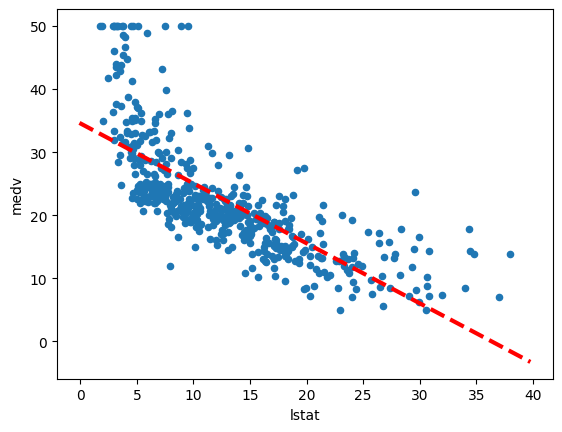

In [16]:
# Graficando el plot (matplotlib la pela :v)
ax = Boston.plot.scatter('lstat', 'medv')
abline(ax, results.params[0], results.params[1], 'r--', linewidth = 3)

# Usando función ya existente

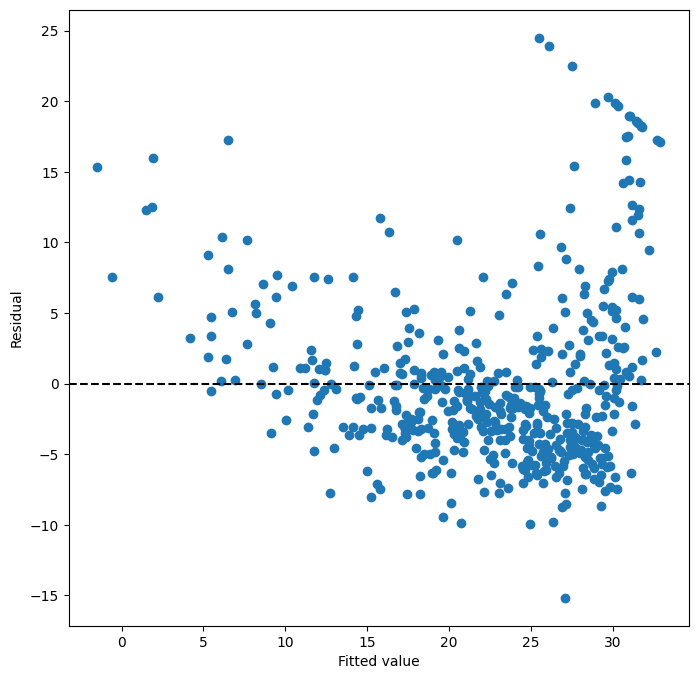

In [17]:
ax = plt.subplots(figsize=(8,8))[1]
ax.scatter(results.fittedvalues , results.resid)
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
ax.axhline(0, c='k', ls='--');

# Leverage

374

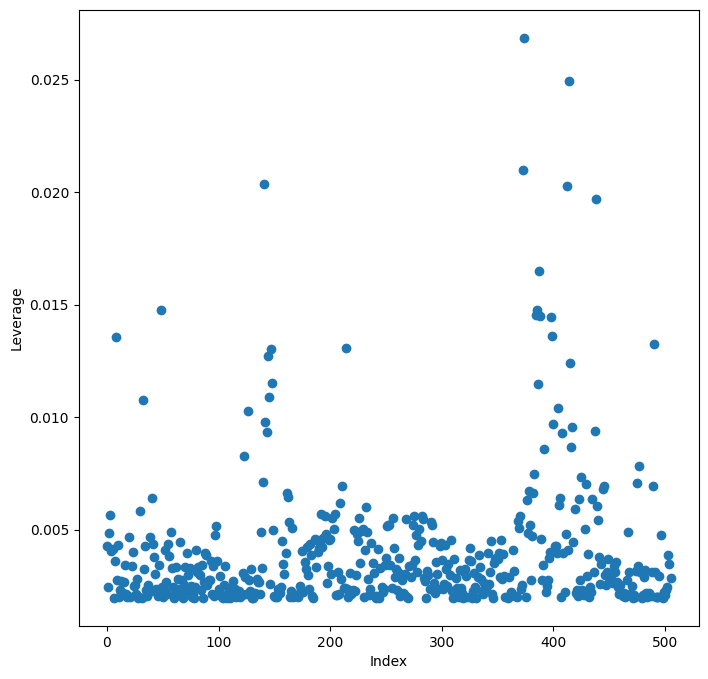

In [18]:
infl = results.get_influence()
ax = plt.subplots(figsize=(8,8))[1]
ax.scatter(np.arange(X.shape[0]), infl.hat_matrix_diag)
ax.set_xlabel('Index')
ax.set_ylabel('Leverage')
np.argmax(infl.hat_matrix_diag)

# Regresión múltiple
Se procede de forma análoga a regresión simple usando la clase ModelSpec() para especificar las covariables del modelo y crear las transformaciones necesarias (matriz de diseño, por ejemplo)

In [19]:
reg_mult = MS(["lstat", "age"])
X = reg_mult.fit_transform(Boston) # Se crea la matriz de diseno para el modelo multiple
model1 = sm.OLS(y, X) # Se recicla la respuesta ya definida
results1 = model1.fit()
summarize(results1) # Tambien se puede usar el metodo propio de los objetos de clase OLS (summary)

,coef,std err,t,P>|t|
intercept,33.2228,0.731,45.458,0.000
lstat,-1.0321,0.048,-21.416,0.000
age,0.0345,0.012,2.826,0.005


**Nota:** En el libro se hacen ejemplos se ilustra cuando se quieren usar todas las covariables o quitar algunas
* En los atributos de los objetos results se pueden obtener de forma individual algunas métricas importantes como el $R^2$, $R^{2}_{Adj}$, $MSE$, etc.
# Factor de inflación de varianza (VIF)

In [20]:
# Se crea la matriz de diseno con todas las covariables para realizar la comparación
X = MS(Boston.drop(columns = "medv").columns).fit_transform(Boston)

# Se usa list comprehension para resumir todo de forma rápida
vals = [VIF(X, i) for i in range(1, X.shape[1])]
vif = pd.DataFrame({'vif':vals}, index = X.columns[1:])
vif

,vif
crim,1.767486
zn,2.298459
indus,3.987181
chas,1.071168
nox,4.369093
rm,1.912532
age,3.088232
dis,3.954037
rad,7.445301
tax,9.002158


# Terminos de interaccion

In [21]:
# Para incluir interacciones, se agrega un tupla dentro de la lista de covariable la cual contiene las variables que van a interactuar
X = MS(['lstat', 'age', ('lstat', 'age')]).fit_transform(Boston)
model2 = sm.OLS(y, X)
summarize(model2.fit())

,coef,std err,t,P>|t|
intercept,36.0885,1.470,24.553,0.000
lstat,-1.3921,0.167,-8.313,0.000
age,-0.0007,0.020,-0.036,0.971
lstat:age,0.0042,0.002,2.244,0.025


# Transformaciones no lineales de predictores

In [22]:
# Por defecto, poly() crea polinomios ortogonales para evitar problemas de multicolinealidad
X = MS([poly('lstat', degree=2), 'age']).fit_transform(Boston)
model3 = sm.OLS(y, X)
results3 = model3.fit()
summarize(results3)

,coef,std err,t,P>|t|
intercept,17.7151,0.781,22.681,0.0
"poly(lstat, degree=2)[0]",-179.2279,6.733,-26.620,0.0
"poly(lstat, degree=2)[1]",72.9908,5.482,13.315,0.0
age,0.0703,0.011,6.471,0.0


# Anova para comparar ajuste cuadratico vs puramente lineal
$$
\begin{cases}
H_0: \text{El submodelo ajusta bien} \\
H_1: \text{El modelo completo es el correcto}
\end{cases}
$$

In [23]:
# results1 es el puramente lineal
# resuñts3 es el modelo con termino cuadratico
anova_lm(results1, results3)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,503.0,19168.128609,0.0,NaN,NaN,NaN
1,502.0,14165.613251,1.0,5002.515357,177.278785,7.468491e-35


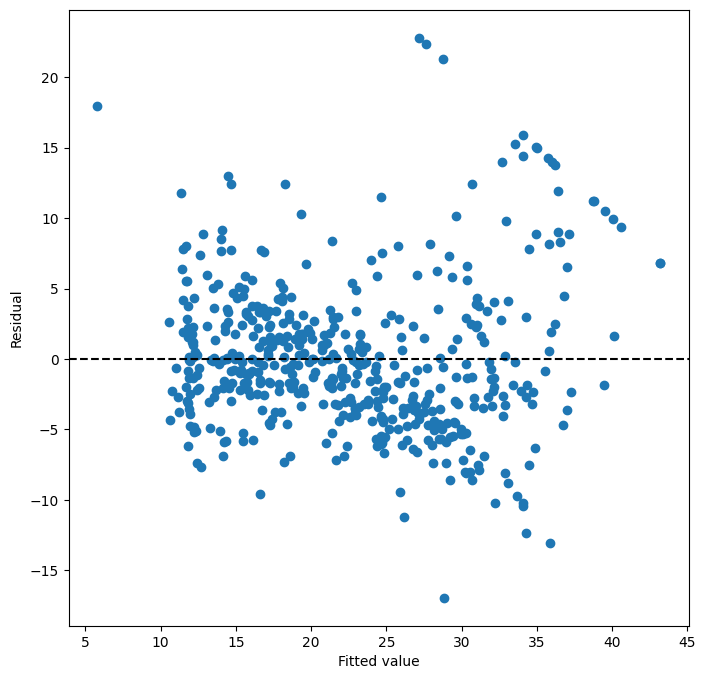

In [24]:
ax = plt.subplots(figsize=(8,8))[1]
ax.scatter(results3.fittedvalues , results3.resid)
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
ax.axhline(0, c='k', ls='--');

Se ve una aparente mejora en los residuales del modelo cuando se incluye el termino cuadrático

# Modelos con variables cualitativas
En este ejemplo se ilustra con la base de datos Carseats

In [25]:
# Carga de base de datos
Carseats = load_data('Carseats')
Carseats.columns

Index(['Sales', 'CompPrice', 'Income', 'Advertising', 'Population', 'Price',
       'ShelveLoc', 'Age', 'Education', 'Urban', 'US'],
      dtype='object')

In [26]:
# Ajuste con variables categoricas
allvars = list(Carseats.columns.drop('Sales'))
y = Carseats['Sales']
final = allvars + [('Income', 'Advertising'), ('Price', 'Age')]
X = MS(final).fit_transform(Carseats)
model = sm.OLS(y, X)
summarize(model.fit())

,coef,std err,t,P>|t|
intercept,6.5756,1.009,6.519,0.000
CompPrice,0.0929,0.004,22.567,0.000
Income,0.0109,0.003,4.183,0.000
Advertising,0.0702,0.023,3.107,0.002
Population,0.0002,0.000,0.433,0.665
Price,-0.1008,0.007,-13.549,0.000
ShelveLoc[Good],4.8487,0.153,31.724,0.000
ShelveLoc[Medium],1.9533,0.126,15.531,0.000
Age,-0.0579,0.016,-3.633,0.000
Education,-0.0209,0.020,-1.063,0.288


# Modelo propio 
## Train - test split

In [27]:
from sklearn.model_selection import train_test_split
# Particicion de entrenamiento y prueba
medv = Boston["medv"]
Boston_train, Boston_test, medv_train, medv_test = train_test_split(Boston, medv, test_size = 0.3, random_state = 3435)

# Resumen de las variables que pueden ser útiles
* rm, lstat -> Mandatorias
* indus, nox, ptratio, tax, rad, chas (categórica) -> Opcionales
* zn y el resto -> Descartadas
Dados los hallazgos encontrados en el descriptivo, se ajusta el modelo mediante mnetodología forward

In [28]:
# Modelo full (para tener una referencia)
diseno_mod_full = MS(Boston.drop(columns = "medv").columns)
Boston_train_mod_full = diseno_mod_full.fit_transform(Boston_train)
mod_full = sm.OLS(medv_train, Boston_train_mod_full)
resultados_mod_full = mod_full.fit()
resultados_mod_full.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.727
Model:                            OLS   Adj. R-squared:                  0.718
Method:                 Least Squares   F-statistic:                     75.81
Date:                Thu, 24 Aug 2023   Prob (F-statistic):           1.59e-88
Time:                        21:20:50   Log-Likelihood:                -1067.6
No. Observations:                 354   AIC:                             2161.
Df Residuals:                     341   BIC:                             2211.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     35.9140      6.327      5.676      0.000      23.469      48.359
crim          -0.1076      0.050     -2.174      0.030      -0.205      -0.010
zn             0.0555      0.016      3.383      0.001       0.023       0.088
indus          0.0013      0.075      0.018      0.986      -0.145       0.148
chas           2.6791      1.070      2.504      0.013       0.575       4.784
nox          -15.3173      4.767     -3.213      0.001     -24.694      -5.941
rm             3.8708      0.550      7.043      0.000       2.790       4.952
age            0.0027      0.017      0.157      0.875      -0.031       0.037
dis           -1.5962      0.256     -6.231      0.000      -2.100      -1.092
rad            0.2322      0.082      2.824      0.005       0.070       0.394
tax           -0.0107      0.005     -2.378      0.018      -0.020      -0.002
ptratio       -0.7581      0.164     -4.625      0.000      -1.080      -0.436
lstat         -0.5988      0.064     -9.335      0.000      -0.725      -0.473
==============================================================================
Omnibus:                      123.082   Durbin-Watson:                   2.112
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              533.893
Skew:                           1.442   Prob(JB):                    1.17e-116
Kurtosis:                       8.280   Cond. No.                     1.20e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.2e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [29]:
# Modelo 1
# Matriz de diseno
diseno_mod1 = MS([poly("lstat", degree = 2), "rm"])
Boston_train_mod1 = diseno_mod1.fit_transform(Boston_train)
mod1 = sm.OLS(medv_train, Boston_train_mod1)
resultados_mod1 = mod1.fit()
resultados_mod1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.710
Model:                            OLS   Adj. R-squared:                  0.708
Method:                 Least Squares   F-statistic:                     286.2
Date:                Thu, 24 Aug 2023   Prob (F-statistic):           8.20e-94
Time:                        21:20:50   Log-Likelihood:                -1078.2
No. Observations:                 354   AIC:                             2164.
Df Residuals:                     350   BIC:                             2180.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept                   -6.5263      3.247     -2.010      0.045     -12.912      -0.140
poly(lstat, degree=2)[0]   -93.6226      6.619    -14.146      0.000    -106.640     -80.605
poly(lstat, degree=2)[1]    45.3936      5.234      8.673      0.000      35.099      55.688
rm                           4.6371      0.514      9.021      0.000       3.626       5.648
==============================================================================
Omnibus:                      100.996   Durbin-Watson:                   2.146
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              447.047
Skew:                           1.148   Prob(JB):                     8.41e-98
Kurtosis:                       8.004   Cond. No.                         167.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
print(f"AIC {resultados_mod1.aic}", f"\nBIC {resultados_mod1.bic}")

AIC 2164.437442875691 
BIC 2179.914630528226


* El modelo resultante presenta un buen ajuste
* $R_{Adj}^2$ = 0.708. 
* AIC = 2164.4374
* BIC = 2179.9146

Se procede a añadir secuencilamente las otras covariables que podrían ser útiles

In [31]:
# Modelo 2: Se anade indus
diseno_mod2 = MS([poly("lstat", degree = 2), "rm", "indus"])
Boston_train_mod2 = diseno_mod2.fit_transform(Boston_train)
mod2 = sm.OLS(medv_train, Boston_train_mod2)
resultados_mod2 = mod2.fit()
resultados_mod2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.713
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                     216.5
Date:                Thu, 24 Aug 2023   Prob (F-statistic):           3.64e-93
Time:                        21:20:50   Log-Likelihood:                -1076.8
No. Observations:                 354   AIC:                             2164.
Df Residuals:                     349   BIC:                             2183.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept                   -7.2424      3.266     -2.218      0.027     -13.666      -0.819
poly(lstat, degree=2)[0]  -100.3196      7.697    -13.034      0.000    -115.458     -85.182
poly(lstat, degree=2)[1]    47.2074      5.329      8.858      0.000      36.726      57.689
rm                           4.6023      0.513      8.969      0.000       3.593       5.611
indus                        0.0822      0.049      1.692      0.092      -0.013       0.178
==============================================================================
Omnibus:                       88.382   Durbin-Watson:                   2.141
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              359.064
Skew:                           1.018   Prob(JB):                     1.07e-78
Kurtosis:                       7.494   Cond. No.                         428.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
print(f"AIC {resultados_mod2.aic}", f"\nBIC {resultados_mod2.bic}")
anova_lm(resultados_mod1, resultados_mod2)

AIC 2163.545914479065 
BIC 2182.892399044734


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,350.0,9164.119112,0.0,NaN,NaN,NaN
1,349.0,9089.570006,1.0,74.549106,2.862362,0.091567


* $R_{Adj}^2 = 0.709$
* AIC = 2163.5459
* BIC = 2182.8924

No vale la pena incluir la variable indus debido al poco incremente de $R_{Adj}^2$ y la poca disminucion del AIC y BIC, además, su nivel de significancia no es del todo baja. El anova de los modelos anidados también sugiere que no vale la pena incluir la variable en el modelo.

In [33]:
# Modelo 3: No se anade indus y se anade nox
diseno_mod3 = MS([poly("lstat", degree = 2), "rm", "nox"])
Boston_train_mod3 = diseno_mod3.fit_transform(Boston_train)
mod3 = sm.OLS(medv_train, Boston_train_mod3)
resultados_mod3 = mod3.fit()
resultados_mod3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.711
Method:                 Least Squares   F-statistic:                     218.4
Date:                Thu, 24 Aug 2023   Prob (F-statistic):           1.23e-93
Time:                        21:20:50   Log-Likelihood:                -1075.7
No. Observations:                 354   AIC:                             2161.
Df Residuals:                     349   BIC:                             2181.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept                   -8.9313      3.401     -2.626      0.009     -15.620      -2.242
poly(lstat, degree=2)[0]  -103.2236      7.845    -13.158      0.000    -118.653     -87.795
poly(lstat, degree=2)[1]    47.4670      5.285      8.981      0.000      37.072      57.862
rm                           4.4585      0.517      8.620      0.000       3.441       5.476
nox                          6.3465      2.823      2.248      0.025       0.794      11.899
==============================================================================
Omnibus:                       83.910   Durbin-Watson:                   2.151
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              344.571
Skew:                           0.958   Prob(JB):                     1.50e-75
Kurtosis:                       7.437   Cond. No.                         196.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [34]:
print(f"AIC {resultados_mod3.aic}", f"\nBIC {resultados_mod3.bic}")
anova_lm(resultados_mod1, resultados_mod3)

AIC 2161.3475036666514 
BIC 2180.6939882323204


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,350.0,9164.119112,0.0,NaN,NaN,NaN
1,349.0,9033.296873,1.0,130.822239,5.054297,0.025189


* $R_{Adj}^2 = 0.711$
* AIC = 2161.3475
* BIC = 2180.694

El añadido de la variable nox no tiene una mejora sustancial respecto al modelo que no la contiene. Aunque la variable parezca significativa, tanto el AIC, BIC siguen siendo muy similares. Se prefiere no incluirla debido al principio de parsimonia

In [35]:
# Modelo 4: Solo se anade ptratio al modelo 1
diseno_mod4 = MS([poly("lstat", degree = 2), "rm", "ptratio"])
Boston_train_mod4 = diseno_mod4.fit_transform(Boston_train)
mod4 = sm.OLS(medv_train, Boston_train_mod4)
resultados_mod4 = mod4.fit()
resultados_mod4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.725
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     230.5
Date:                Thu, 24 Aug 2023   Prob (F-statistic):           1.42e-96
Time:                        21:20:50   Log-Likelihood:                -1068.8
No. Observations:                 354   AIC:                             2148.
Df Residuals:                     349   BIC:                             2167.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept                    6.0501      4.279      1.414      0.158      -2.366      14.467
poly(lstat, degree=2)[0]   -86.2782      6.669    -12.937      0.000     -99.395     -73.161
poly(lstat, degree=2)[1]    41.2823      5.190      7.954      0.000      31.075      51.490
rm                           4.3536      0.505      8.613      0.000       3.359       5.348
ptratio                     -0.5865      0.134     -4.368      0.000      -0.851      -0.322
==============================================================================
Omnibus:                      136.890   Durbin-Watson:                   2.178
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              833.128
Skew:                           1.494   Prob(JB):                    1.23e-181
Kurtosis:                       9.896   Cond. No.                         514.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
print(f"AIC {resultados_mod4.aic}", f"\nBIC {resultados_mod4.bic}")
anova_lm(resultados_mod1, resultados_mod4)

AIC 2147.591329504433 
BIC 2166.937814070102


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,350.0,9164.119112,0.0,NaN,NaN,NaN
1,349.0,8689.002572,1.0,475.116539,19.083395,0.000017


* $R_{Adj}^2 = 0.722$
* AIC = 2147.5913
* BIC = 2166.9378

La variable es significativa y aunque no incrementa mucho el $R_{Adj}^2$ sí logra una disminución del AIC respecto al modelo 1 por lo que se decide dejarla en el modelo.

In [37]:
# Modelo 5
diseno_mod5 = MS([poly("lstat", degree = 2), "rm", "ptratio", "rad"])
Boston_train_mod5 = diseno_mod5.fit_transform(Boston_train)
mod5 = sm.OLS(medv_train, Boston_train_mod5)
resultados_mod5 = mod5.fit()
resultados_mod5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     184.6
Date:                Thu, 24 Aug 2023   Prob (F-statistic):           1.45e-95
Time:                        21:20:50   Log-Likelihood:                -1068.3
No. Observations:                 354   AIC:                             2149.
Df Residuals:                     348   BIC:                             2172.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept                    7.3801      4.499      1.641      0.102      -1.468      16.228
poly(lstat, degree=2)[0]   -89.0650      7.275    -12.243      0.000    -103.373     -74.757
poly(lstat, degree=2)[1]    41.3984      5.192      7.974      0.000      31.187      51.610
rm                           4.2391      0.519      8.162      0.000       3.218       5.261
ptratio                     -0.6384      0.145     -4.410      0.000      -0.923      -0.354
rad                          0.0361      0.038      0.960      0.338      -0.038       0.110
==============================================================================
Omnibus:                      125.073   Durbin-Watson:                   2.171
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              691.052
Skew:                           1.376   Prob(JB):                    8.71e-151
Kurtosis:                       9.267   Cond. No.                         642.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
print(f"AIC {resultados_mod5.aic}", f"\nBIC {resultados_mod5.bic}")
anova_lm(resultados_mod4, resultados_mod5)

AIC 2148.655763255323 
BIC 2171.8715447341256


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,349.0,8689.002572,0.0,NaN,NaN,NaN
1,348.0,8666.069225,1.0,22.933347,0.920926,0.337898


* $R_{Adj}^2 = 0.722$
* AIC = 2148.6558
* BIC = 2171.8715

La variable no es significativa y el anova sugiere que la inclusión de la variable es innecesaria

In [39]:
# Modelo 6
diseno_mod6 = MS([poly("lstat", degree = 2), "rm", "ptratio", "chas"])
Boston_train_mod6 = diseno_mod6.fit_transform(Boston_train)
mod6 = sm.OLS(medv_train, Boston_train_mod6)
resultados_mod6 = mod6.fit()
resultados_mod6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     192.7
Date:                Thu, 24 Aug 2023   Prob (F-statistic):           6.27e-98
Time:                        21:20:50   Log-Likelihood:                -1062.8
No. Observations:                 354   AIC:                             2138.
Df Residuals:                     348   BIC:                             2161.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept                    6.3639      4.214      1.510      0.132      -1.924      14.652
poly(lstat, degree=2)[0]   -85.4883      6.570    -13.012      0.000     -98.410     -72.566
poly(lstat, degree=2)[1]    41.1140      5.110      8.046      0.000      31.064      51.164
rm                           4.2135      0.499      8.439      0.000       3.232       5.196
ptratio                     -0.5697      0.132     -4.307      0.000      -0.830      -0.310
chas                         3.5212      1.014      3.472      0.001       1.526       5.516
==============================================================================
Omnibus:                      119.604   Durbin-Watson:                   2.188
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              701.409
Skew:                           1.284   Prob(JB):                    4.91e-153
Kurtosis:                       9.400   Cond. No.                         515.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
print(f"AIC {resultados_mod6.aic}", f"\nBIC {resultados_mod6.bic}")
anova_lm(resultados_mod4, resultados_mod6)

AIC 2137.5381595764175 
BIC 2160.75394105522


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,349.0,8689.002572,0.0,NaN,NaN,NaN
1,348.0,8398.134949,1.0,290.867624,12.052906,0.000582


* $R_{Adj}^2 = 0.731$
* AIC = 2137.5382
* BIC = 2160.7539

La variable categórica se deja en el modelo debido a la disminución en el AIC y el ligero aumento del $R_{Adj}^2$, además esta resulta significativa y la anova sugiere que mejora el ajuste

# Modelo final
Luego de hacer el forward previo, se llega al modelo teórico final

${\text{medv}} = \beta_0 + \beta_1 \ \text{lstat} + \beta_2 \ \text{lstat}^2 + \beta_3 \text{rm} + \beta_4 \text{ptratio} + \beta_5 \text{chas} + \varepsilon$ 

cuyos valores estimados se encuentran en el summary del obejto resultados_mod6

# Algunos chequeos
## Residuales vs valores ajustados

In [41]:
# Con el método outlier_test() se pueden obtener los residuales studentizados
out_test = resultados_mod6.outlier_test()
out_test[out_test["bonf(p)"] != 1] # Para detectar los outliers en la prueba de bonferroni

,student_resid,unadj_p,bonf(p)
369,3.176416,1.624803e-03,0.575180
371,5.920220,7.729226e-09,0.000003
372,5.396326,1.262549e-07,0.000045
368,5.474479,8.430375e-08,0.000030
364,-4.325963,1.988126e-05,0.007038


In [42]:
# Guardando residuales studentizados en otro objeto
stud_resid = resultados_mod6.outlier_test()["student_resid"]
# Guardando valores ajustados en otro objeto
ajustados = resultados_mod6.fittedvalues

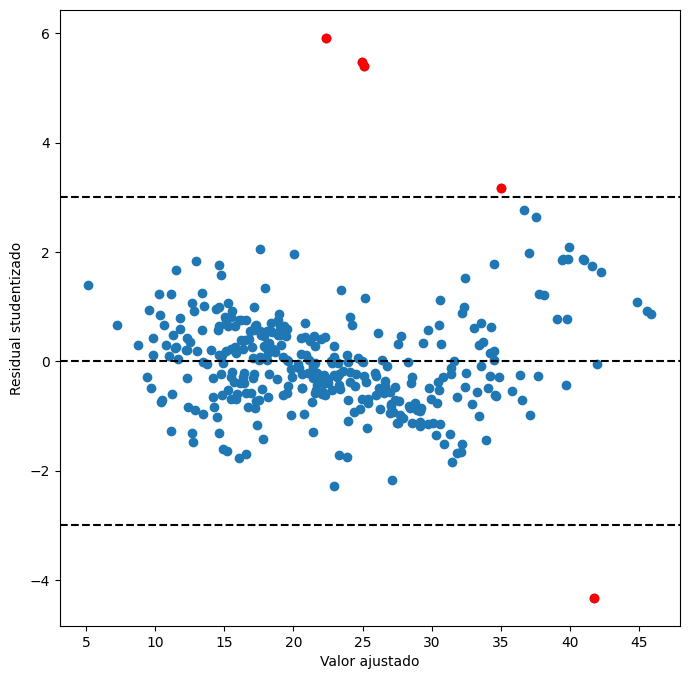

In [43]:
# Indices de ouliers
out_index = out_test[out_test["bonf(p)"] != 1].index # outliers segun prueba de bonferroni
resultados_mod6.fittedvalues.loc[list(out_index)]
ax = plt.subplots(figsize=(8,8))[1]
ax.scatter(ajustados, stud_resid)
ax.scatter(ajustados[list(out_index)], stud_resid[list(out_index)], c = "r") # Para pintar los outliers de rojo
ax.set_xlabel('Valor ajustado')
ax.set_ylabel('Residual studentizado')
[ax.axhline(y = i, linestyle = '--', c = "k") for i in [-3, 0, 3]];

* Podría existir carencia de ajuste debido a la aparente recta existente formada por unos outliers superiores y otros puntos en los límites normales, haciendo caso omiso de lo anterior, los residuales no muestran patrones claros.
* Los outliers, son las observaciones 369, 371, 372, 368, 364.
* No hay indicios de que se este violando el supuesto de homocedasticidad

## Leverage

In [44]:
# Puntos de alta influencia
influence = resultados_mod6.get_influence()
leverage = pd.Series(influence.hat_matrix_diag, index = Boston_train.index)
cutoff = 6/354 # (p + 1)/n
infl_index = leverage[leverage > cutoff].index

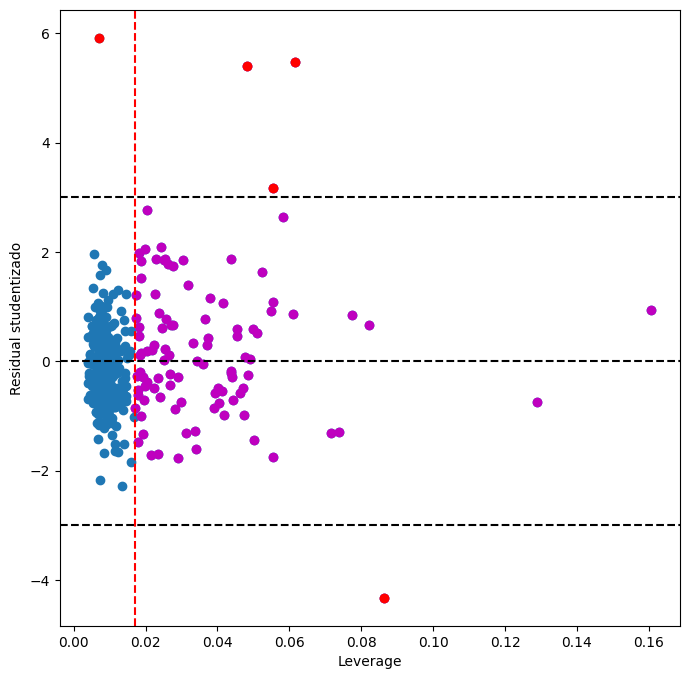

In [45]:
ax = plt.subplots(figsize=(8,8))[1]
ax.scatter(leverage, stud_resid)
ax.scatter(leverage[list(infl_index)], stud_resid[list(infl_index)], c = "m") # Para pintar los outliers de rojo
ax.scatter(leverage[list(out_index)], stud_resid[list(out_index)], c = "r") # Para pintar los outliers de rojo
ax.set_xlabel('Leverage')
ax.set_ylabel('Residual studentizado')
ax.axvline(x = cutoff, ls = "--", c = "r")
[ax.axhline(y = i, linestyle = '--', c = "k") for i in [-3, 0, 3]];

In [46]:
# Deteccion de outliers influyentes
out_infl_index = np.intersect1d(out_index, infl_index)
Boston_train.loc[out_infl_index]

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
364,3.47428,0.0,18.1,1,0.718,8.780,82.9,1.9047,24,666,20.2,5.29,21.9
368,4.89822,0.0,18.1,0,0.631,4.970,100.0,1.3325,24,666,20.2,3.26,50.0
369,5.66998,0.0,18.1,1,0.631,6.683,96.8,1.3567,24,666,20.2,3.73,50.0
372,8.26725,0.0,18.1,1,0.668,5.875,89.6,1.1296,24,666,20.2,8.88,50.0


## Errores normales

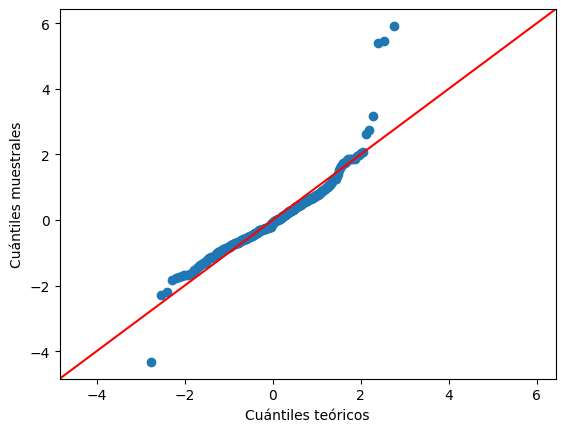

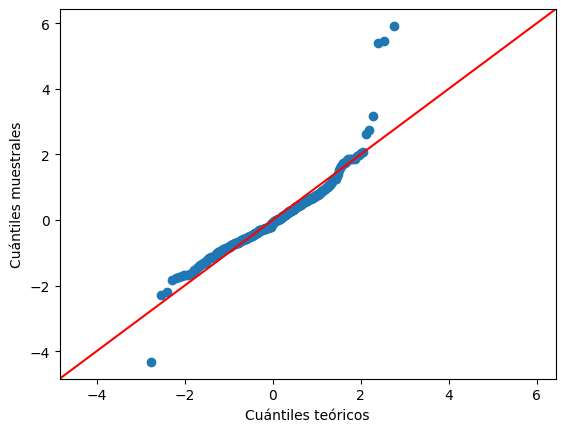

In [47]:
# Residuales estandarizados
sm.qqplot(stud_resid, line = "45", xlabel = "Cuántiles teóricos", ylabel = "Cuántiles muestrales")

# RMSE de train vs test

In [48]:
from sklearn.metrics import mean_squared_error as MSE
# RMSE de entrenamiento
rmse_train = MSE(medv_train, resultados_mod6.fittedvalues, squared = False)

# Prediciones en test
Boston_test_diseno = diseno_mod6.transform(Boston_test) #Definiendo la matriz de diseno para predecir los valores de test
predicciones_test = resultados_mod6.get_prediction(Boston_test_diseno) # Objeto para guardar predicciones e ics de los valores de test
medv_pred_test = pd.Series(predicciones_test.predicted_mean, index = Boston_test.index)
# RMSE de prueba
rmse_test = MSE(medv_test, medv_pred_test, squared = False)
# RMSE train vs test
print(f"Train {rmse_train.round(4)}", 
    f"\nTest  {rmse_test.round(4)}", 
    f"\nError relativo de train - test {(100 * abs(rmse_train - rmse_test)/rmse_train).round(4)} %")

Train 4.8707 
Test  4.3809 
Error relativo de train - test 10.0564 %


In [49]:
# Exportacion de test a csv
Boston_test.to_csv('Boston_Test_Juanjo.csv')